In [1]:
import numpy as np 
import emcee
import corner
import h5py
import astropy.units as u
import os
import scipy

In [2]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

In [3]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

## Bayesian Inference and Markov Chain Monte Carlo for the Ambient Solar Wind Speed

In this problem, we use Bayesian inference and Markov chain Monte Carlo (MCMC) to find the parameters of
a chain of models that are used in space weather forecasting (of the ambient solar wind velocity near Earth). We assume the model and data are connected by 
$$
Z_{i} = f(X; t_{i}) + \epsilon_{i}
$$
where $X = \{v_{1}, \alpha, \beta, w, \gamma\} \in \mathbb{R}^{5}$ is the set of uncertain parameters, $f(X, t_{i})$ is the chain of *PFSS-WSA-HUX* models at time instance $t_{i}$, $\epsilon$ represents the discrepancies between the model and data, and is typically assumed to be Gaussian distributed with mean zero and standard deviation $\mathbf{\sigma}$, and $Z_{i}$ is the the radial velocity meassured at time $t_{i}$ at L1. The radial velocity at L1 is meassured via SWEPAM monitor on ACE. 

### Formulation of Bayesian posterior distribution for the model parameters $x = [v_{1}, \alpha, \beta, w, \gamma]$ given the above information.


The prior is given by 
$$
\mathbb{P}(x) = \mathbb{P}(v_{1})\mathbb{P}(\alpha)\mathbb{P}(\beta)\mathbb{P}(w)\mathbb{P}(\gamma) = \left\{
\begin{array}{ll}
      \frac{1}{44.22} & \qquad 550 \leq v_{1} \leq 950, \qquad 0.05 \leq \alpha \leq 0.5, \qquad 1\leq \beta \leq 1.75, \qquad 0.01 \leq w \leq 0.4, \qquad 0.06 \leq \gamma \leq 0.9 \\
      0 & \text{otherwise} \\
\end{array} 
\right. 
$$
since the uncertain parameters $v_{1}, \alpha, \beta, w, \gamma$ are independent.

From Bayes' rule, the posterior is given by:
$$
\mathbb{P}(x|z) = \frac{\mathbb{P}(z|x) \mathbb{P}(x)}{\mathbb{P}(z)} = \frac{\mathbb{P}(z|x) \mathbb{P}(x)}{\int_{\mathbb{R}^{5}} \mathbb{P}(z|x)\mathbb{P}(x)\text{d}z} \propto \mathbb{P}(z|x) \mathbb{P}(x) 
$$

The log-posterior is given by 
$$
\log{\mathbb{P}(x|z)} = \log{\frac{\mathbb{P}(z|x) \mathbb{P}(x)}{\int_{\mathbb{R}^{5}} \mathbb{P}(z|x)\mathbb{P}(x)\text{d}z}} = \log{\mathbb{P}(z|x)} + \log{\mathbb{P}(x)} - \log{\int_{\mathbb{R}^{5}} \mathbb{P}(z|x)\mathbb{P}(x)\text{d}z}
$$

The log-prior is given by 
$$
\log{\mathbb{P}(x)} = \left\{
\begin{array}{ll}
      \log{\frac{1}{44.22}} &\qquad 550 \leq v_{1} \leq 950, \qquad 0.05 \leq \alpha \leq 0.5, \qquad 1\leq \beta \leq 1.75, \qquad 0.01 \leq w \leq 0.4, \qquad 0.06 \leq \gamma \leq 0.9 \\
      -\infty & \text{otherwise} \\
\end{array} 
\right. 
$$

The likelihood function  updates our belief state by measuring the misfit between the data $z_{i}$ and model predictions $f(x; t_{i})$ with a specific parameter set. Since we assume additive Gaussian measurement noise wth zero mean, i.e. $\epsilon  \in \mathcal{N}(0, \sigma)$, the measurements are $z_{i}$ independent across observations, conditional on the parameters $x$, i.e., $z_{1}$ and $z_{2}$ are independent given $x^{(1)}$ and $x^{(2)}$. Using the independence assumption, we can write the likelihood function as
$$
\mathbb{P}(z|x) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^{2}}} \exp \left( - \frac{1}{2\sigma^{2}} [z_{i} - f(x; t_{i})]^{2} \right) \propto \exp \left( - \frac{1}{2\sigma^{2}} \sum_{i=1}^{n}  [z_{i} - f(x; t_{i}) ]^{2} \right).
$$

### MCMC
Here, we use a Python implemtation of the affine-invariant ensemble sampler for Markov chain Monte Carlo (MCMC) proposed by Goodman & Weare (2010).

In [4]:
reader = emcee.backends.HDFBackend("MCMC_results/MCMC_CR2054.h5")

nburnin = 1000
samples = reader.get_chain(flat=False, discard=nburnin)
samples_flatten  = reader.get_chain(flat=True, discard=nburnin)
log_prob_samples = reader.get_log_prob(flat=False, discard=nburnin)
log_prior_samples = reader.get_blobs(flat=False, discard=nburnin)

n_iter = np.shape(samples)[0]
n_walkers = np.shape(samples)[1]
n_dim = np.shape(samples)[2]

print("flat chain shape: {0}".format(samples.shape))
print("num of iterations: {0}".format(reader.iteration))

flat chain shape: (25000, 250, 5)
num of iterations: 26000


In [5]:
print("acceptance ratio:", np.mean(reader.accepted/(reader.iteration)))

acceptance ratio: 0.33593184615384614


### Log-likelihood in parameter space

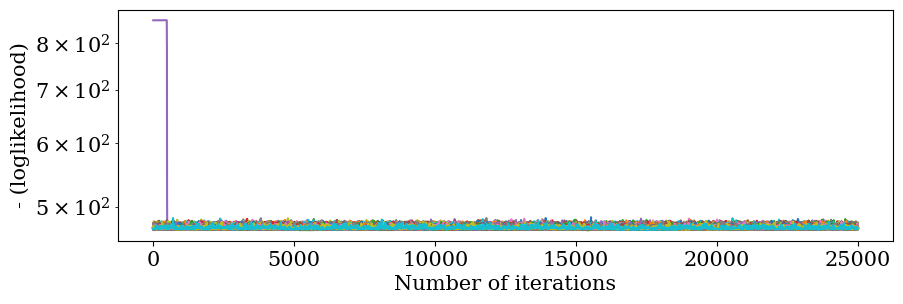

In [6]:
fig, ax = plt.subplots(figsize=(10, 3))
for ii in range(n_walkers):
    _ = ax.plot(-log_prob_samples[:, ii])
_ = ax.set_yscale("log")
_ = ax.set_ylabel("- (loglikelihood)")
_ = ax.set_xlabel("Number of iterations")

### A corner plot to show correlation of the five model parameters.

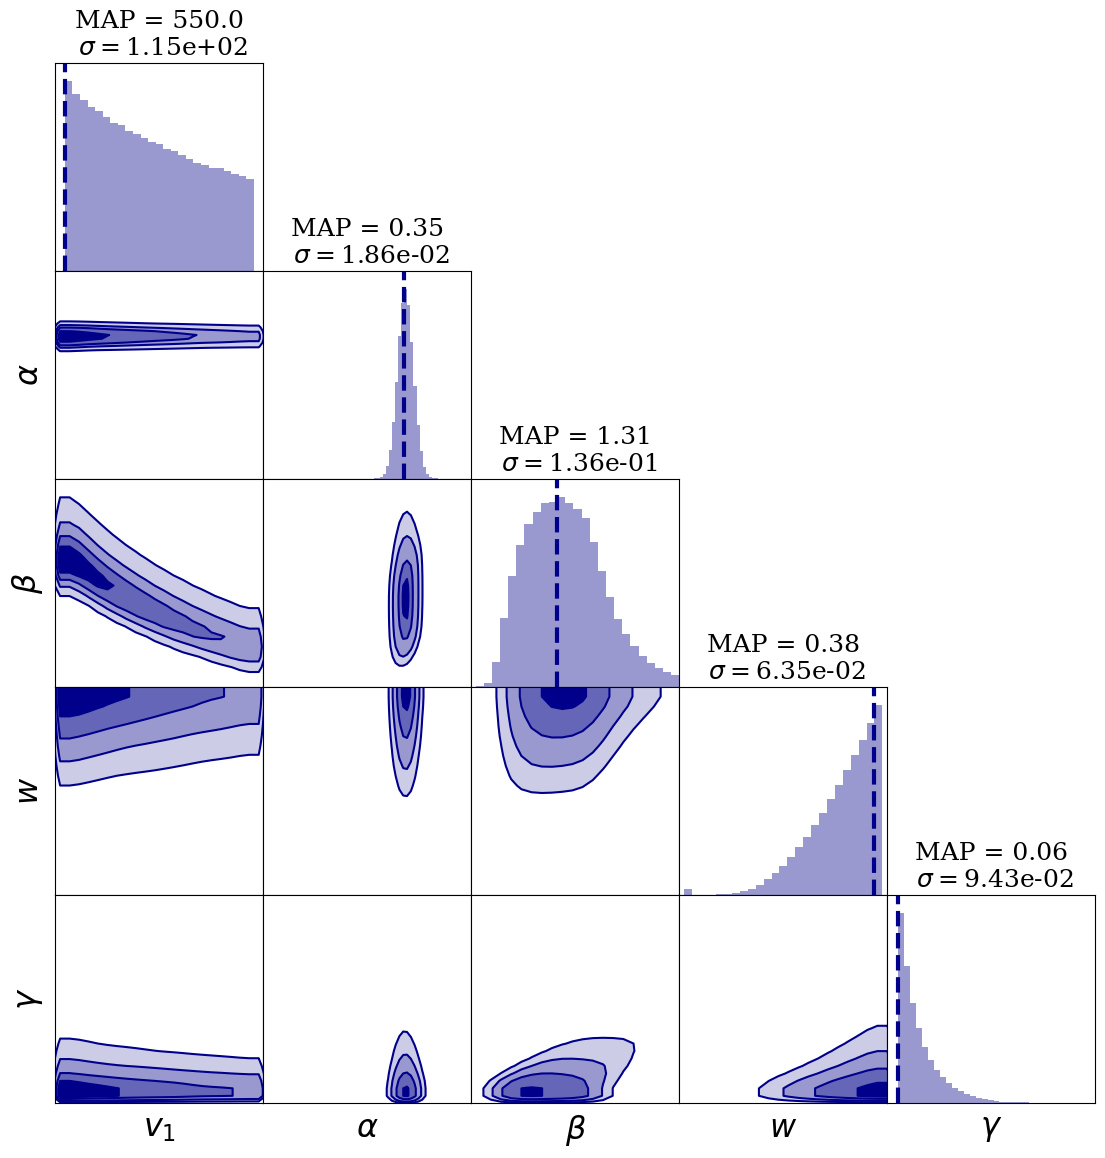

In [7]:
labels_list = [r"$v_{1}$", r"$\alpha$", r"$\beta$", r"$w$", r"$\gamma$"]
MAP = []
fig = corner.corner(samples_flatten, figsize=(4, 3), 
                    fontsize=30, smooth=1, 
                    no_fill_contours=True, plot_contours=True, 
                    plot_density ="bone_r",
                    color="darkblue",
                    fill_contours=True, 
                    plot_datapoints=False)

# Extract the axes
axes = np.array(fig.axes).reshape((n_dim, n_dim))

for ii in range(n_dim):
    ax = axes[ii, ii]
    ax.clear()
    sigma = np.std(np.ndarray.flatten(samples[:,:, ii]))
    n , bins, _ = ax.hist(np.ndarray.flatten(samples[:,:, ii]), 
                          25, density=1, 
                          color="darkblue", 
                          linewidth=3, 
                         alpha=0.4)
    ax.set_ylim(0, np.max(n)*1.1)
    ax.set_xticks([])
    ax.set_yticks([])
    MAP.append(bins[np.where(n == n.max())])
    ax.axvline(bins[np.where(n == n.max())], label="$MAP$", color="darkblue", ls="--", linewidth=3)
    ax.set_title("MAP = " + str(round(bins[np.where(n == n.max())][0], 2))
            +"\n $\sigma = $" + "{:.2e}".format(np.std(samples[:,:, ii])), fontsize=18)
    if ii==0:
        ax.set_xlim(530, 970)
    elif ii==1:
        ax.set_xlim(0.01, 0.51)
    elif ii==2:
        ax.set_xlim(1, 1.75)
    elif ii==3:
        ax.set_xlim(0, 0.41)
    elif ii==4:
        ax.set_xlim(0.01, 1)

# loop over the histograms
for yi in range(n_dim):
    for xi in range(n_dim):
        if xi < yi:
            ax = axes[yi, xi]
            if yi==4:
                ax.set_xlabel(labels_list[xi], fontsize=23)
            if xi==0:
                ax.set_ylabel(labels_list[yi], fontsize=23)
            ax.set_xticks([])
            ax.set_yticks([])
            
            if xi==0:
                ax.set_xlim(530, 970)
            elif xi==1:
                ax.set_xlim(0.01, 0.51)
            elif xi==2:
                ax.set_xlim(1, 1.75)
            elif xi==3:
                ax.set_xlim(0, 0.41)
            elif xi==4:
                ax.set_xlim(0.01, 1)
                
            if yi==0:
                ax.set_ylim(530, 970)
            elif yi==1:
                ax.set_ylim(0.01, 0.51)
            elif yi==2:
                ax.set_ylim(1, 1.75)
            elif yi==3:
                ax.set_ylim(0, 0.41)
            elif yi==4:
                ax.set_ylim(0.01, 1)
            
            
axes[-1, -1].set_xticks([])
axes[-1, -1].set_xlabel(labels_list[-1], fontsize=23)
fig.subplots_adjust(wspace=0, hspace=0)

## Diagnostics for MCMC

**1) Mixing of the Chain (Heuristic):**
Good mixing occurs when more of the domain is explored. Bad mixing occurs when the step size is too large and most proposals are rejected, resulting in less space being explored. 

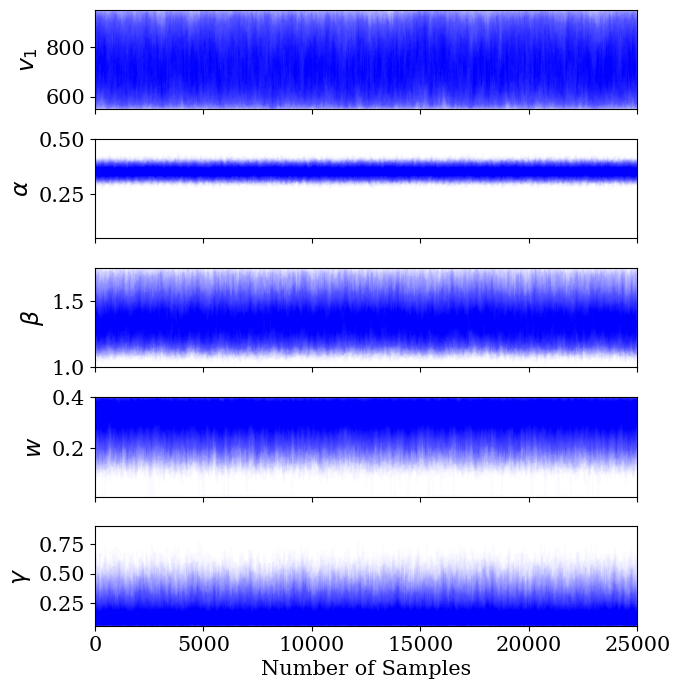

In [8]:
fig, ax = plt.subplots(nrows=n_dim, sharex=True, figsize=(7, 8))

for ii in range(n_dim):
    ax[ii].plot(samples[:,:, ii], '-', alpha=0.01, c="b")
    ax[ii].set_ylabel(labels_list[ii], fontsize=17)
    
ax[-1].set_xlabel("Number of Samples")
ax[0].set_ylim(550, 950)
ax[1].set_ylim(0.05, 0.5)
ax[2].set_ylim(1, 1.75)
ax[3].set_ylim(0.01, 0.4)
ax[4].set_ylim(0.06, 0.9)
ax[0].set_xlim(0, n_iter)

fig.subplots_adjust(wspace=0, hspace=0.3)

**2) Autocorrelation:** Autocorrelation draws from the fundamental property of a Markov chain: *every Markov chain is memoryless*. We can compute the autocorrelation of states which are $\ell$ iterations apart as
$$
R(\ell) \equiv \frac{\sum_{i=1}^{n-\ell} (X_{i} -\bar{X})(X_{i+\ell} - \bar{X})}{\sum_{i=1}^{n} (X_{i} - \bar{X})^2}
$$
where $\bar{X}$ is the mean.

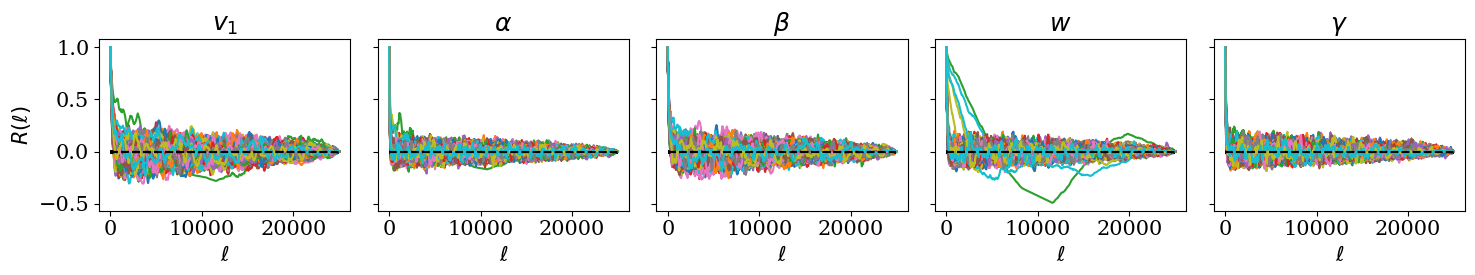

In [9]:
fig, ax = plt.subplots(ncols=n_dim, sharey=True, figsize=(15, 3))
for jj in range(n_dim):
    for ii in np.arange(0, n_walkers):
        ax[jj].plot(emcee.autocorr.function_1d(samples[:, ii, jj].T))
        ax[jj].set_xlabel("$\ell$")
        ax[jj].hlines(0, xmin=0, xmax=len(samples[:, 0, 0]), color="k", ls="--")
    ax[jj].set_title(str(labels_list[jj]))
ax[0].set_ylabel("$R(\ell)$")

plt.tight_layout()

**3) Integrated Autocorrelation (IAC) and Effective Sample Size (ESS):** In standard MC, the variance of the estimator is 
$$
\mathbb{V}\text{ar} \left( \frac{1}{N} \sum_{i=1}^{N} f(X^{(i)})\right) = \frac{\mathbb{V}\text{ar}(f(X))}{N}, \qquad X^{(i)} \sim i.i.d.
$$
In MCMC, samples are correlated, so we get additional covariance terms. If we assume that all $X_{i}$ and $X_{j}$ are samples from the target distribution, then we can approximate the variance of the MCMC estimator as 
$$
\mathbb{V}\text{ar}\left(\bar{f}(X)^{\text{MCMC}}\right) = \mathbb{V}\text{ar} \left( \frac{1}{N} \sum_{i=1}^{N} f(X^{(i)})\right) = \frac{\mathbb{V}\text{ar}\left(f(X) \right)}{N} \cdot \theta
$$
where the integrated autocorrelation (IAC) $\theta$ is defined as 
$$
\theta = \sum_{\tau=-\infty}^{\infty} \rho_{f}(\tau)
$$
where $\rho_{f}(\tau)$ is the normalized autocorrelation function of the stochastic process that generated the chain for $f$. You can estimate $\rho_{f}(\tau)$ using a finite chain $\{ f_{n}\}_{n=1}^{N}$ as 
$$
\hat{\rho}_{f}(\tau) = \hat{c}_{f}(\tau)/\hat{c}_{f}(0)
$$
where 
$$
\hat{c}_{f}(\tau) = \frac{1}{N-\tau} \sum_{n=1}^{N-\tau} (f_{n} - \mu_{f}) (f_{n+\tau} - \mu_{f})
$$
and 
$$
\mu_{f} = \frac{1}{N} \sum_{n=1}^{N} f_{n}.
$$
We stimate $\theta$ using the estimator for $\rho_{f}(\tau)$ as 
$$
\theta(M) = 1 + 2 \sum_{\tau=1}^{M} \hat{\rho}_{f}(\tau)
$$
The effective sample size of MCMC is then $\frac{N}{\theta}$ and we want $\frac{N}{\theta} \ll 1$. Essentially, $\theta$ is the number of steps that are needed before the chain "forgets" where it started. Once we estimate $\theta$ then we can estimate the number of samples that we need to generate to reduce the relative error on the target inegral. Typically, parallel chains longer than $50\theta$ are often sufficient. 

The integrated autocorrelation time is an estimate of the number of steps needed in the chain in order to draw independent samples from the target density. A more efficient chain has a shorter autocorrelation time.

In [10]:
tau = reader.get_autocorr_time(discard=nburnin)
print("More than N=" + str(np.max(tau*50)) + " samples in each chain is sufficient.")

More than N=17127.967602354103 samples in each chain is sufficient.
